In [1]:
%load_ext autoreload

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tifffile
import os
from pathlib import Path

import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader

from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

import zarr
import gunpowder as gp

In [3]:
class CustomDataset(Dataset):
    def __init__(self, raw_root_dir, gt_root_dir=None, augment=False):
        
        self.raw_root_dir = raw_root_dir
        self.gt_root_dir = gt_root_dir
        self.augment = augment
        
        self.samples = self._get_samples(self.raw_root_dir)
        if self.gt_root_dir is not None:
            self.gt_samples = self._get_samples(self.gt_root_dir)
        
        self.prepare_augmentation_pipeline()
    
    def prepare_augmentation_pipeline(self):
        self._raw = gp.ArrayKey('RAW')
        self._gt = gp.ArrayKey('GROUND_TRUTH')  
        # create "pipeline" consisting only of a data source
        _input_arr = self.__getitem__(5)
        self._source = gp.ZarrSource(
            self.raw_root_dir,  # the zarr container
            {self._raw: 'raw'},  # which dataset to associate to the array key
            {self._raw: gp.ArraySpec(interpolatable=True),
            }  # meta-information
        )
        self._pipeline = self._source

    def test_augment(self):
        # formulate a request for "raw"
        request = gp.BatchRequest()
        request[self._raw] = gp.Roi((0, 0), (64, 64))

        # build the pipeline...
        with gp.build(self._pipeline):

          # ...and request a batch
          batch = self._pipeline.request_batch(request)
        
        return batch
    
    def augmentation(self, image, groundTruth=None):
        pass
            
    def __len__(self):
        return len(self.samples)        
    
    def __getitem__(self, idx, augment=False):
                    
        img_path = os.path.join(self.raw_root_dir, self.samples[idx])
        return img_path
        img = zarr.array(tifffile.imread(img_path))
        
        if self.gt_root_dir is not None:
            gt_img_path = os.path.join(self.gt_root_dir, self.gt_samples[idx])
            gt_img = zarr.array(tifffile.imread(gt_img_path))           
            
            if self.augment:
                img, gt_img = self.augmentation(image=img, groundTruth=gt_img)
            return img, gt_img
        
        if self.augment:
            img, gt_img = self.augmentation(image=img)
        return img
    
    def __view_item__(self, idx):
        '''
        displays 5 random images from set
        '''

        images = self.__getitem__(idx, self.augment)

        if isinstance(images, tuple):
            raw_imgs, gt_imgs = images
            n_cols = 2
        else:
            raw_imgs = images
            n_cols = 1
                
        random_ints = np.random.randint(0, raw_imgs.shape[0], 5)

        fig, ax = plt.subplots(5,n_cols, figsize=(14,14))
        if n_cols == 2:
            for i in range(len(random_ints)):
                rand_idx = random_ints[i]
                ax[i][0].imshow(raw_imgs[rand_idx])
                ax[i][0].set_title(f'raw image z {rand_idx}')

                ax[i][1].imshow(gt_imgs[rand_idx])
                ax[i][1].set_title(f'gt image z {rand_idx}')
        else:
            for i in range(len(random_ints)):
                rand_idx = random_ints[i]
                ax[i].imshow(raw_imgs[rand_idx])
                ax[i].set_title(f'raw image z {rand_idx}')
                
        plt.tight_layout()
        plt.show()
        

    @staticmethod
    def _get_samples(_path):
        return sorted(os.listdir(_path))

In [63]:
CustomDataset(data_path).test_augment()

something went wrong during the setup of the pipeline, calling tear down


PathNotFoundError: nothing found at path ''

In [45]:
CustomDataset(data_path, ).__getitem__(3)

<zarr.core.Array (59, 349, 639) uint16>

In [ ]:
## NEW START

In [7]:
data_path = '/home/loringm/Downloads/SIMULATED_DATASET/01'
gt_path = '/home/loringm/Downloads/SIMULATED_DATASET/01_GT/SEG'

def folder_to_zarr(data_path):
    ### quite slow because does it really shitty ###
    
    imgs = []
    with os.scandir(data_path) as entries:
        for entry in entries:
            if entry.name.endswith('tif'):
                imgs.append(tifffile.imread(Path(data_path).joinpath(entry.name).as_posix()))
                
    intermediate = np.array(imgs)
    zarr.array(['raw'] : intermediate)
    
    zarr.save(Path(data_path).joinpath('data.zarr'), mode='w')
    
folder_to_zarr(data_path)
folder_to_zarr(gt_path)

In [57]:
    
    imgs = []
    with os.scandir(gt_path) as entries:
        for entry in entries:
            if entry.name.endswith('tif'):
                imgs.append(tifffile.imread(Path(gt_path).joinpath(entry.name).as_posix()))
                
    intermediategt = np.array(imgs)


In [52]:
    
    imgs = []
    with os.scandir(data_path) as entries:
        for entry in entries:
            if entry.name.endswith('tif'):
                imgs.append(tifffile.imread(Path(data_path).joinpath(entry.name).as_posix()))
                
    intermediate = np.array(imgs)


In [53]:
intermediate

array([[[[ 93, 101,  94, ...,  88,  95,  87],
         [ 98,  97,  95, ...,  98,  98,  91],
         [ 96,  85,  89, ...,  84,  91,  87],
         ...,
         [ 92,  92,  90, ...,  87,  99,  88],
         [ 87,  90,  96, ...,  95,  87,  93],
         [ 94,  90,  86, ...,  97,  92,  91]],

        [[ 93,  97,  89, ...,  96,  96,  95],
         [ 89,  88,  92, ...,  95,  94,  91],
         [ 94,  97,  89, ...,  94,  98,  94],
         ...,
         [ 94,  95,  87, ...,  89,  85,  88],
         [ 92,  93,  91, ...,  98,  96,  89],
         [ 89,  96,  94, ...,  90,  97,  95]],

        [[ 89,  93,  96, ...,  82,  90, 101],
         [ 95,  99,  94, ...,  87,  96,  92],
         [ 94,  86,  89, ...,  89,  90,  93],
         ...,
         [ 95,  92,  91, ...,  97,  90,  88],
         [ 92,  92,  96, ...,  87,  87,  92],
         [ 92,  93,  88, ...,  93,  93,  96]],

        ...,

        [[ 90,  93,  94, ...,  89,  92,  94],
         [ 94,  86,  87, ...,  89,  95,  89],
         [ 99,  94

In [11]:
_raw = gp.ArrayKey('RAW')
_source = gp.ZarrSource(
    Path(data_path).joinpath('data.zarr'),  # the zarr container
    {_raw: 'raw'},  # which dataset to associate to the array key
    {_raw: gp.ArraySpec(interpolatable=True),
    }  # meta-information
)
request = gp.BatchRequest()
request[_raw] = gp.Roi((0, 0), (64, 64))
_pipeline = _source


# build the pipeline...
with gp.build(_pipeline):

  # ...and request a batch
  batch = _pipeline.request_batch(request)

something went wrong during the setup of the pipeline, calling tear down


RuntimeError: raw not in /home/loringm/Downloads/SIMULATED_DATASET/01/data.zarr

In [25]:
z = zarr.open(Path(data_path).joinpath('data.zarr').as_posix(), mode='w')

In [42]:
z.tree()

Tree(nodes=(Node(disabled=True, name='/'),))

In [43]:
a = zarr.group()

In [44]:
a.create_group('RAW')

<zarr.hierarchy.Group '/RAW'>

In [54]:
a['RAW'] = intermediate

In [56]:
a['RAW']

<zarr.core.Array '/RAW' (150, 59, 349, 639) uint16>

In [58]:
a.create_group('GT')

<zarr.hierarchy.Group '/GT'>

In [59]:
a['GT'] = intermediategt

In [66]:
a['GT']

<zarr.core.Array '/GT' (150, 59, 349, 639) uint16>

In [80]:
root = zarr.open('data/example.n5', mode='w')

In [81]:
rawData = root.create_group('RAW')

In [84]:
rawData['data'] = intermediate
rawData['resolution'] = intermediate.shape
rawData['offset'] = (0,0)

In [74]:
root['GT'] = intermediategt

In [75]:
root['RAW'] = intermediate

In [77]:
GT = root.create_group('GT')

In [ ]:
GT['raw'] = inte

In [71]:
GT = intermediategt

In [78]:
rawData = root.create_group('RAW')

In [79]:
rawData['raw'] = intermediate

In [68]:
a.open('/home/loringm/Downloads/SIMULATED_DATASET.n5', 'a')

AttributeError: 

In [78]:
 self._raw = gp.ArrayKey('RAW')
        self._gt = gp.ArrayKey('GROUND_TRUTH')  
        # create "pipeline" consisting only of a data source
        _input_arr = self.__getitem__(5)
        self._source = gp.ZarrSource(
            self.raw_root_dir,  # the zarr container
            {self._raw: 'raw'},  # which dataset to associate to the array key
            {self._raw: gp.ArraySpec(interpolatable=True),
            }  # meta-information
        )
        self._pipeline = self._source

    def test_augment(self):
        # formulate a request for "raw"
        request = gp.BatchRequest()
        request[self._raw] = gp.Roi((0, 0), (64, 64))

        # build the pipeline...
        with gp.build(self._pipeline):

          # ...and request a batch
          batch = self._pipeline.request_batch(request)
        
        return batch

<zarr.core.Array (150, 59, 349, 639) uint16>

In [71]:
Path(data_path).joinpath(entry.name)

'/home/loringm/Downloads/SIMULATED_DATASET/01/t006.tif'

In [32]:
r, g = CustomDataset(data_path, gt_path).__getitem__(_ind)

In [ ]:
f = zarr.open('sample_data.zarr', 'w')

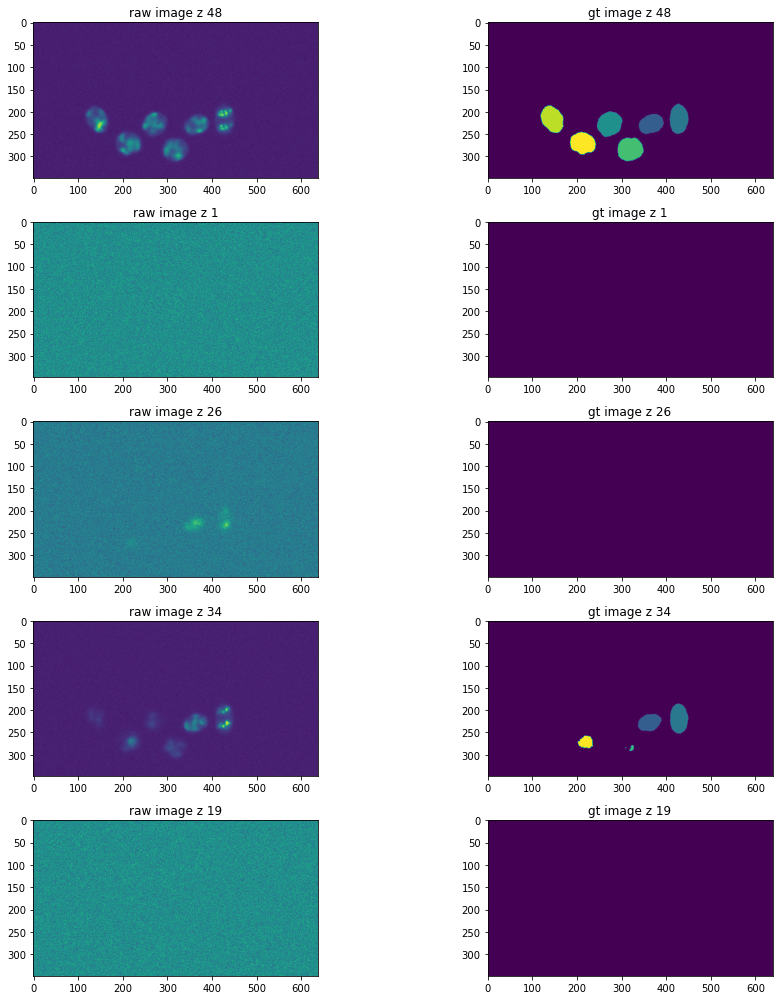

In [20]:
CustomDataset(data_path, gt_path).__view_item__(_ind)